# Procesamiento Adaptativo de Señales Aleatorias
# Trabajo Práctico N°1 - Estimación espectral no-paramétrica
## Grupo 3
* Santiago Arribere
* Matías Francois
* Joaquín Gaytan
* Pablo Scheinfeld

## TODO
* Agregar la otra zona de ruido
* Agregar %%time a todo
* Verificar labels de ejes en gráficos ('GPS time'), algunos faltantes
* Shift en frecuencia
* Estacionareidad
* Cambiar whiten

In [1]:
import h5py
import numpy as np
import scipy.signal as sps
import matplotlib.pyplot as plt
from IPython.display import Audio

## 1. Leyendo archivos hdf5
La información de la señal se ofrece en archivos copn extensión *hdf5*, destinados a almacenar la metadata del experimento. De ellos se extrae la señal (*strain*), así como el tiempo GPS en el que comienza la grabación (de forma tal de ubicar el evento en cuestión) y la frecuencia de muestreo de ambas señales.

In [2]:
def read_ligo(filename):
    f = h5py.File(filename, 'r')
    strain = f['strain/Strain'][...]
    fs = 1/ f['strain/Strain'].attrs['Xspacing']
    start_time = f['meta/GPSstart'][()]
    f.close()
    return strain, start_time, fs

In [3]:
# Open hdf5 files
h1_s, h1_st, h1_fs = read_ligo('../assets/data/h1_32sec_4khz.hdf5')
l1_s, l1_st, l1_fs = read_ligo('../assets/data/l1_32sec_4khz.hdf5')

In [4]:
event_start_gps = 1126259462
event_start = event_start_gps - h1_st
event_delta = 0.2
time = np.arange(0,h1_s.shape[0]/h1_fs, 1/h1_fs)

Dado que una hipótesis importante del análisis subsiguiente es que las señales involucradas tengan media nula, se procede a restar la media estimada a ambas señales. Posteriormente se grafica el resultado apreciado en ambos interferómetros.

In [5]:
# Substract mean to signals
h1_s -= np.mean(h1_s)
l1_s -= np.mean(l1_s)

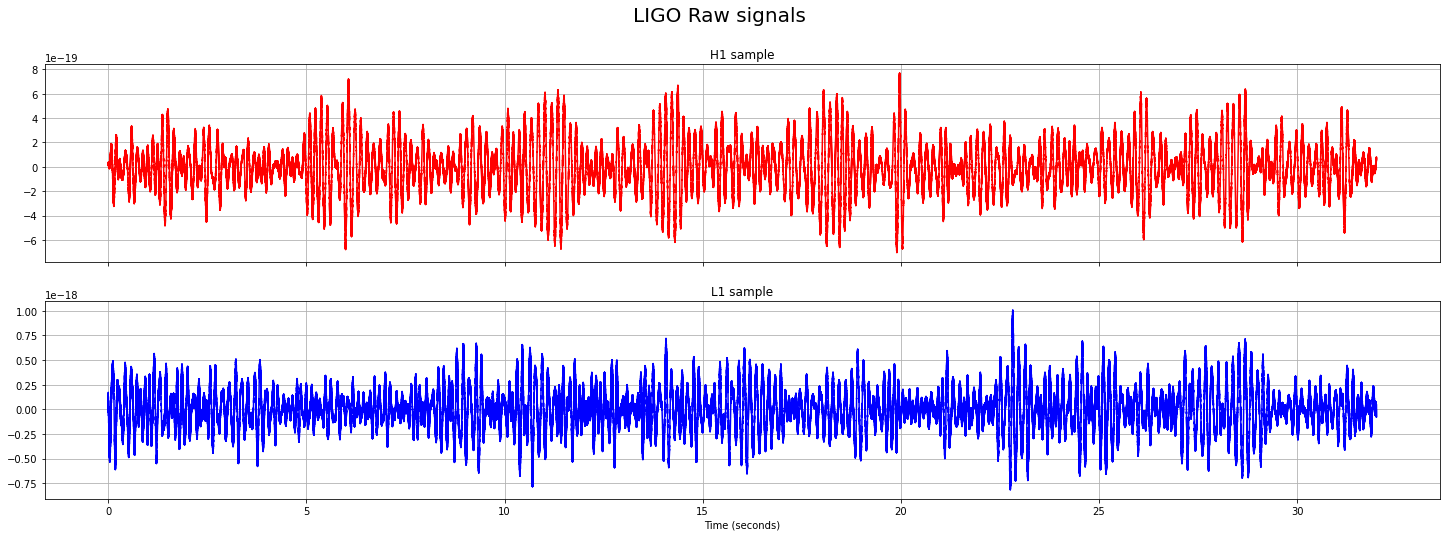

In [6]:
# Plot raw signals
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Raw signals', fontsize=20)
axs[0].plot(time, h1_s, color='red')
axs[1].plot(time, l1_s, color='blue')
axs[0].set_title('H1 sample')
axs[1].set_title('L1 sample')
axs[1].set_xlabel('Time (seconds)')
axs[0].grid()
axs[1].grid()

Estas señales contienen tanto el evento de ondas gravitatorias como ruido. Para poder recuperar la señal del evento, se busca estimar el espectro de ruido. Luego, conociendo la ubicación aproximada de detección de las ondas (tiempo GPS = 1126259462 segundos) se procede a separar a las dos señales en tres segmentos: dos segmentos de ruido al comienzo y al final, y una ventana de 4 segundos alrededor del evento.

In [7]:
# Using a 4 second window to ensure catching events in both sites
h1_event = h1_s[(time >= event_start-2) & (time <= event_start + 2)]
l1_event = l1_s[(time >= event_start-2) & (time <= event_start + 2)]
time_event = time[(time >= event_start-2) & (time <= event_start + 2)]

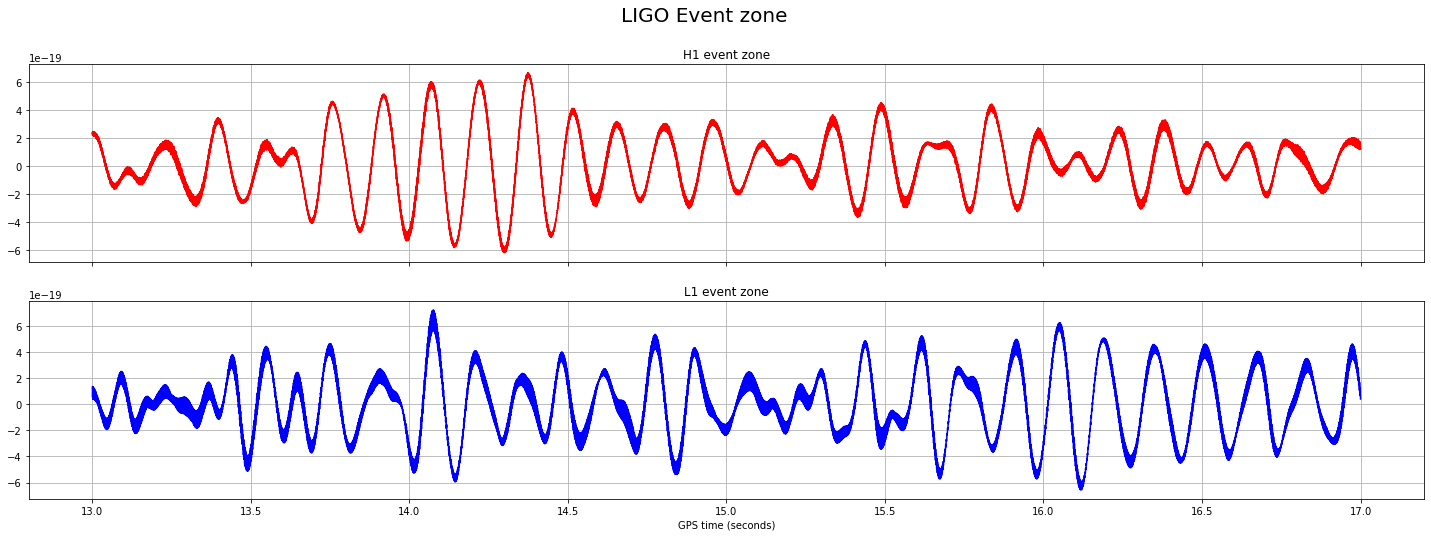

In [8]:
# Plot raw events
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Event zone',fontsize=20)
axs[0].plot(time_event, h1_event, color='red')
axs[1].plot(time_event, l1_event, color='blue')
axs[0].set_title('H1 event zone')
axs[1].set_title('L1 event zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

In [9]:
# Get silence (noise)
h1_silence = h1_s[(time > event_start + 2)]
l1_silence = l1_s[(time > event_start + 2)]
time_silence = time[(time > event_start + 2)]

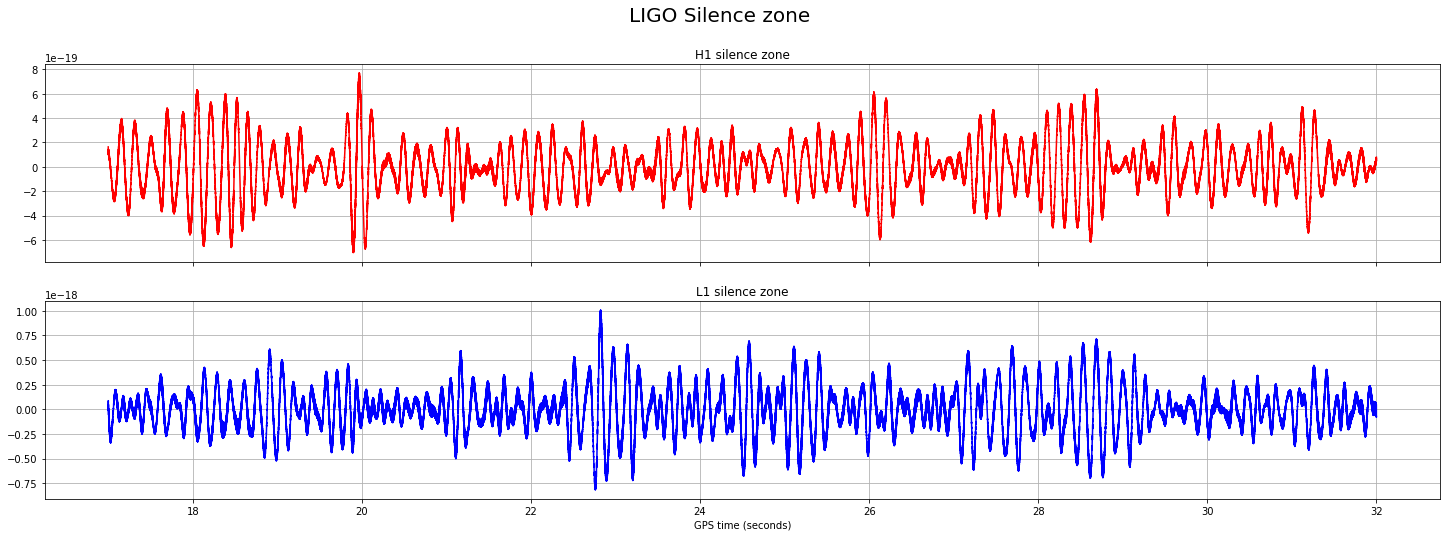

In [10]:
# Plot raw events
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Silence zone',fontsize=20)
axs[0].plot(time_silence, h1_silence, color='red')
axs[1].plot(time_silence, l1_silence, color='blue')
axs[0].set_title('H1 silence zone')
axs[1].set_title('L1 silence zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

# Estimating noise psd

In [11]:
from ej1.periodogram import periodogram
from ej1.per_averaging import periodogram_averaging
from ej1.per_smoothing import periodogram_smoothing

## Periodogram

In [12]:
def plot_periodogram(ax, fs, signal, window):
    f, per = periodogram(signal, window=window)
    f *= fs
    ax.loglog(f,per, label=window)
    ax.grid(axis='both', which='both')

Wall time: 275 ms


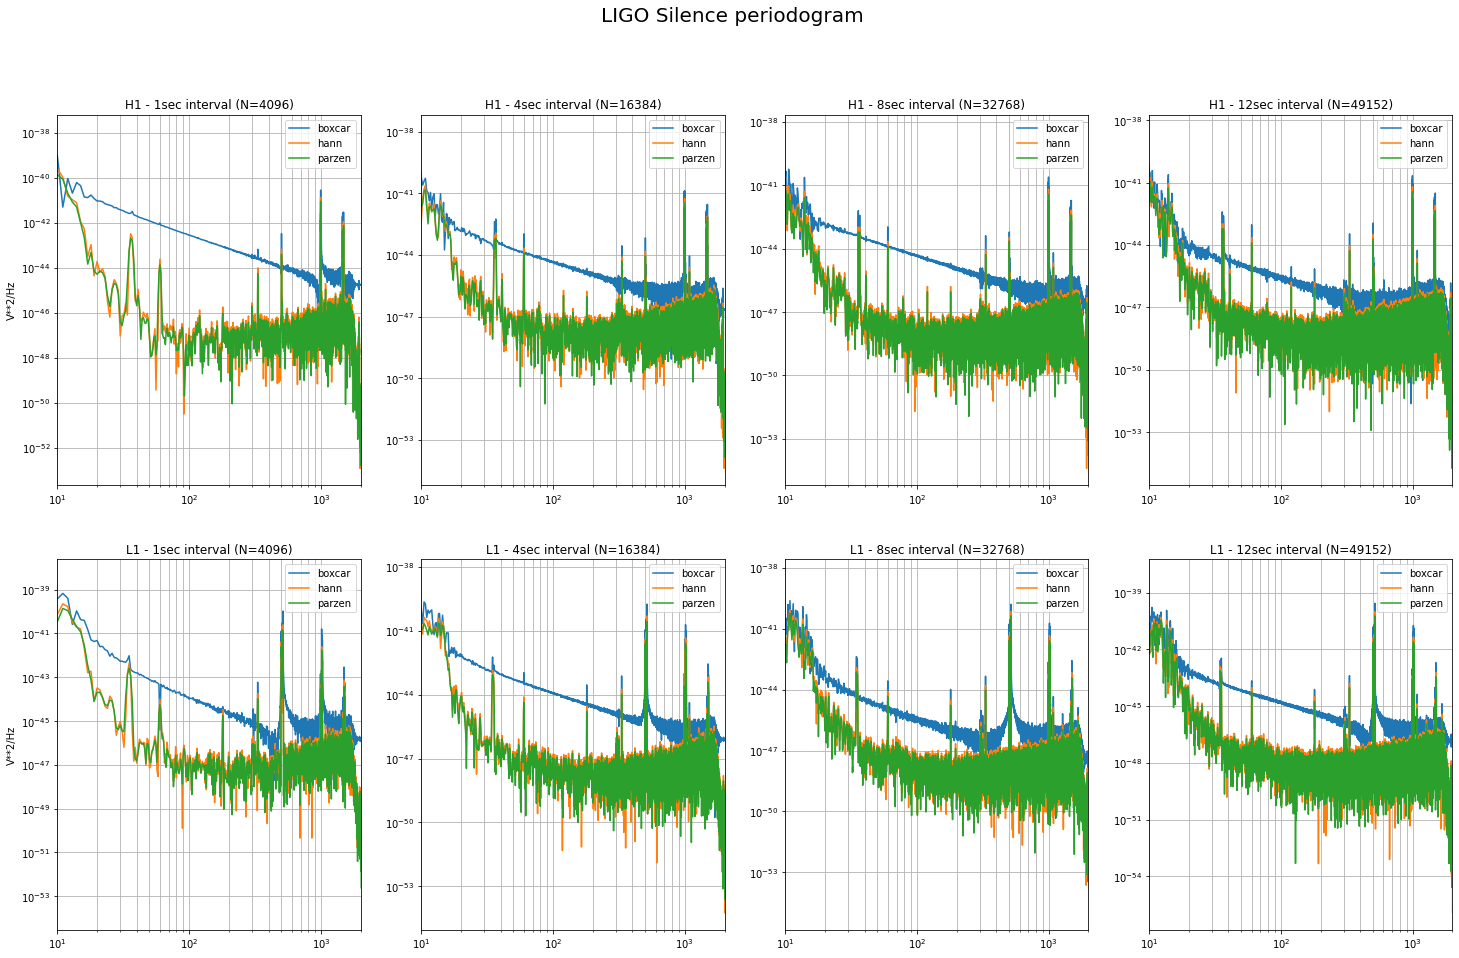

In [13]:
%%time
windows = ['boxcar', 'hann', 'parzen']
samples = [1,4,8,12]
signals = [h1_silence, l1_silence]

fig, axs = plt.subplots(2, 4, figsize=(25,15))
fig.suptitle('LIGO Silence periodogram', fontsize=20)
axs[0][0].set_ylabel('V**2/Hz')
axs[1][0].set_ylabel('V**2/Hz')
for i, s in enumerate(signals):
    for j,sample in enumerate(samples):
        for w in windows:
            plot_periodogram(axs[i][j], h1_fs, s[:int(sample*h1_fs)], w)
        tag = 'H1' if i == 0 else 'L1'
        axs[i][j].set_title(f'{tag} - {sample}sec interval (N={int(sample*h1_fs)})')
        axs[i][j].legend()
        axs[i][j].set_xlim(10,2000)  

## Periodogram averaging

In [14]:
def plot_periodogram_avg(ax, fs, signal, k, overlap):
    D = int(signal.shape[0] / k)
    L = int(D / (1-overlap))
    f, per = periodogram_averaging(signal, k, L)
    f *= fs
    ax.loglog(f,per, label=f'{o*100}% overlap')
    ax.grid(axis='both', which='both')

Wall time: 456 ms


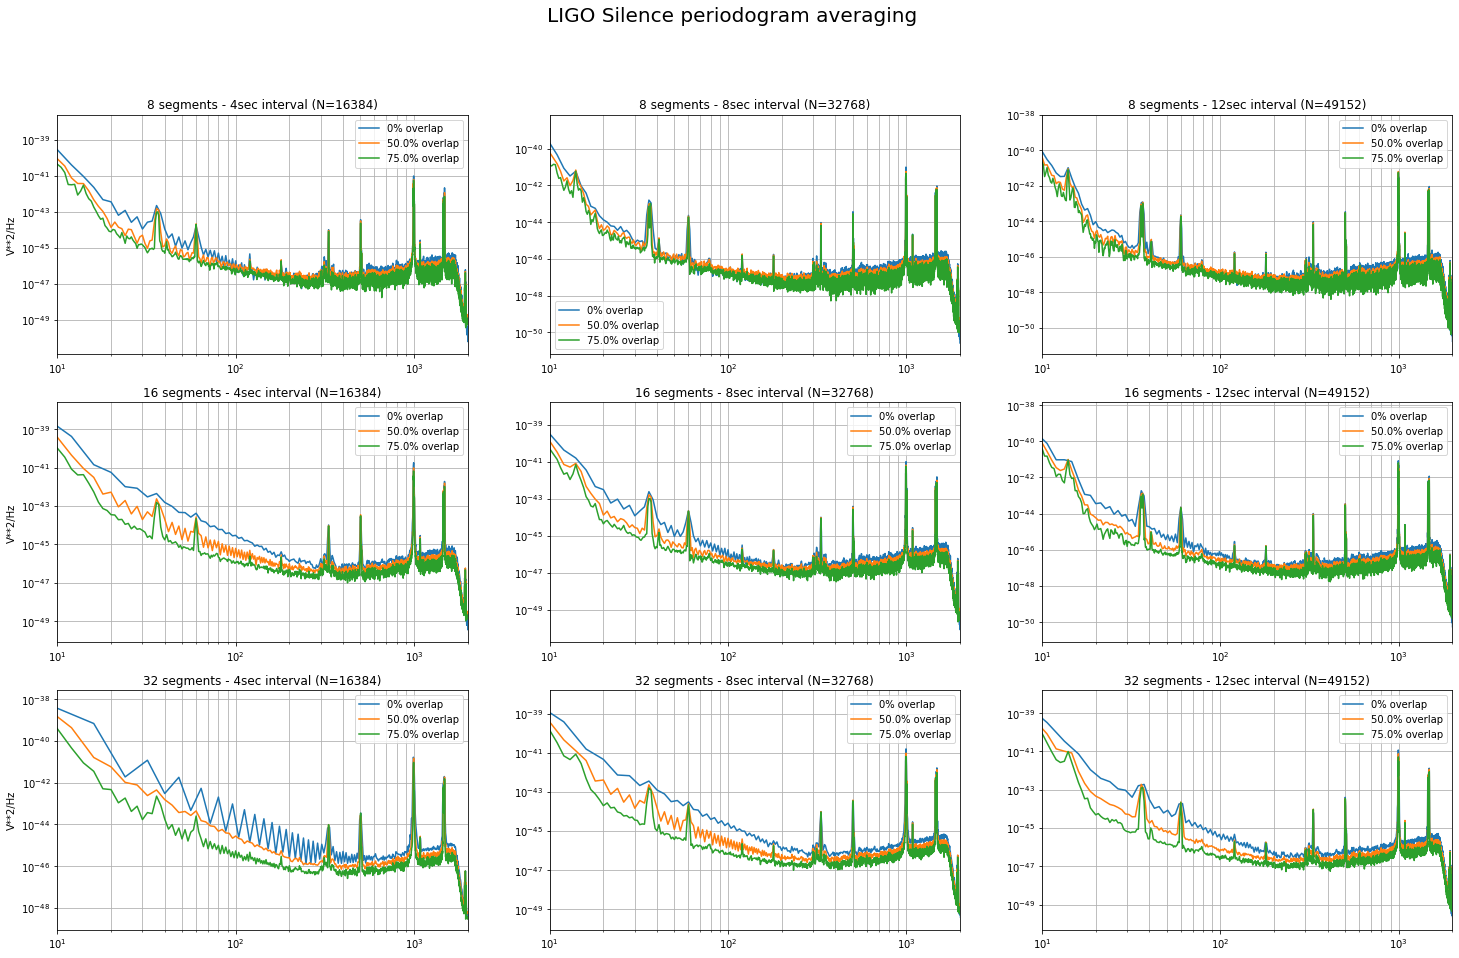

In [15]:
%%time
segments = [8, 16, 32]
samples = [4,8,12]
overlaps = [0,0.5, 0.75]

fig, axs = plt.subplots(3, 3, figsize=(25,15), tight_layout=False)
fig.suptitle('LIGO Silence periodogram averaging', fontsize=20)
axs[0][0].set_ylabel('V**2/Hz')
axs[1][0].set_ylabel('V**2/Hz')
axs[2][0].set_ylabel('V**2/Hz')

for i, k in enumerate(segments):
    for j,sample in enumerate(samples):
        for o in overlaps:
            plot_periodogram_avg(axs[i][j], h1_fs, h1_silence[:int(sample*h1_fs)], k, o)
        axs[i][j].set_title(f'{k} segments - {sample}sec interval (N={int(sample*h1_fs)})')
        axs[i][j].legend()
        axs[i][j].set_xlim(10,2000)        

## Periodogram smoothing

In [16]:
def plot_periodogram_smoothing(ax, fs, signal, L, window):
    f, per = periodogram_smoothing(signal, L, window=window, M=50)
    f *= fs
    ax.loglog(f,per, label=window)
    ax.grid(axis='both', which='both')

Wall time: 59 s


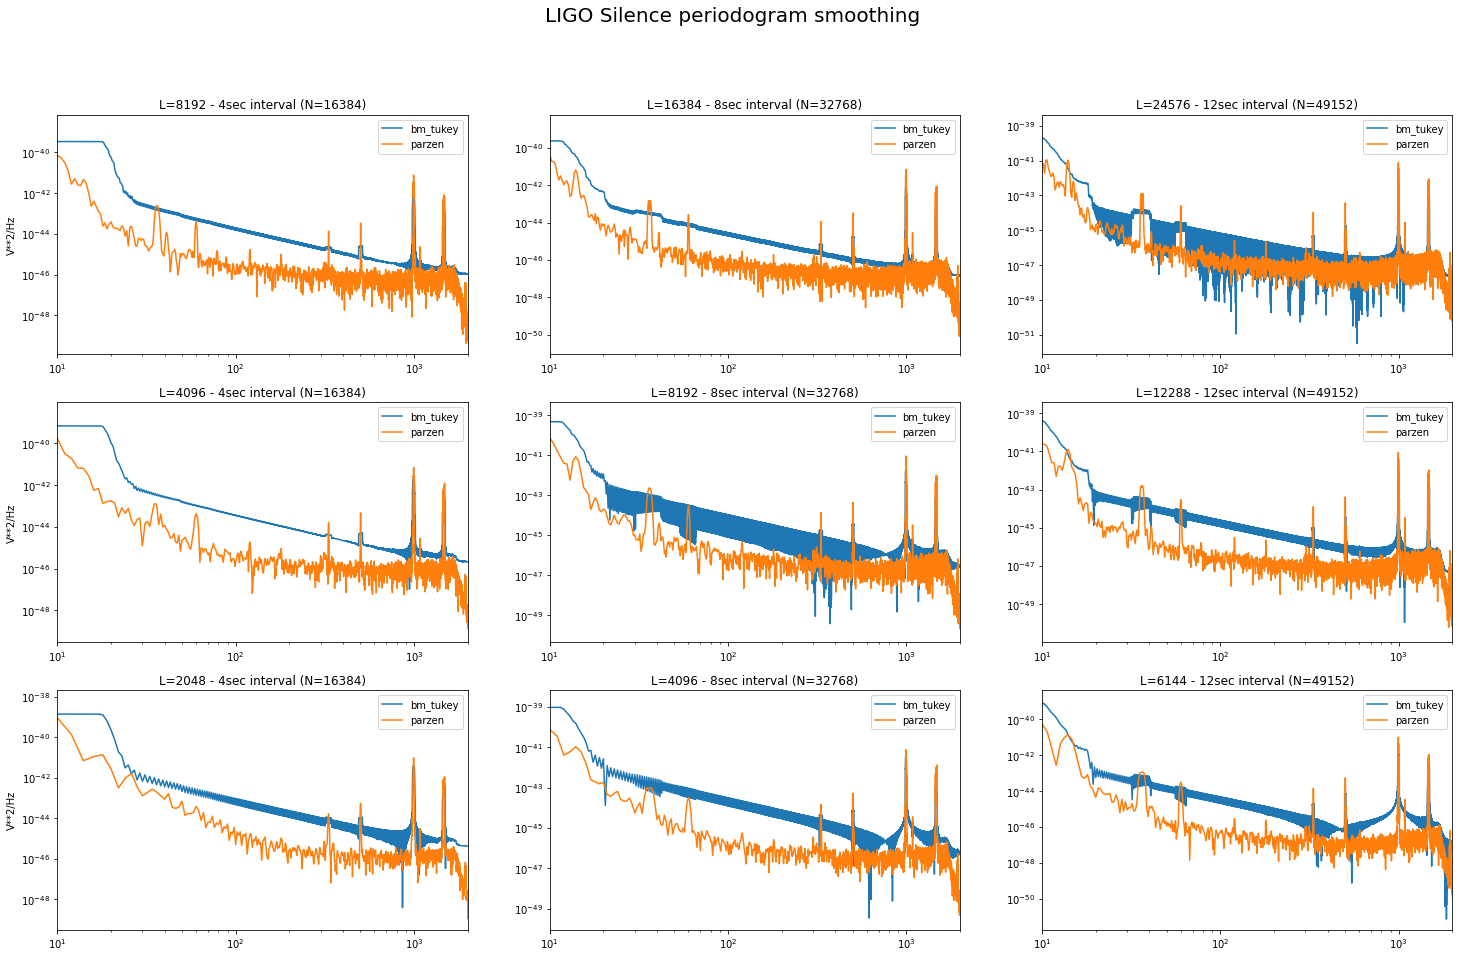

In [17]:
%%time
lengths = [2, 4, 8]
samples = [4,8,12] # seconds
windows = ['bm_tukey', 'parzen']

fig, axs = plt.subplots(3, 3, figsize=(25,15))
fig.suptitle('LIGO Silence periodogram smoothing', fontsize=20)
axs[0][0].set_ylabel('V**2/Hz')
axs[1][0].set_ylabel('V**2/Hz')
axs[2][0].set_ylabel('V**2/Hz')

for i, L in enumerate(lengths):
    for j,sample in enumerate(samples):
        for w in windows:
            plot_periodogram_smoothing(axs[i][j], h1_fs, h1_silence[:int(sample*h1_fs)], int(sample*h1_fs/L), w)
        axs[i][j].set_title(f'L={int(sample*h1_fs/L)} - {sample}sec interval (N={int(sample*h1_fs)})')
        axs[i][j].legend()
        axs[i][j].set_xlim(10,2000)

## Best psd estimation

In [18]:
%%time
# Best periodogram parameters
N = int(4*h1_fs)
window = 'parzen'

h1_per_f, h1_per_best = periodogram(h1_silence[:N], window=window)
l1_per_f, l1_per_best = periodogram(l1_silence[:N], window=window)

Wall time: 6.5 ms


In [19]:
%%time
# Best PA model parameters
k = 16              # 16 Segments
N = int(12*h1_fs)    # 12 secs
overlap = 0.5  #0.5

D = N // k
L = int(D / (1-overlap))
h1_pa_f, h1_pa_best = periodogram_averaging(h1_silence[:N], k, L)
l1_pa_f, l1_pa_best = periodogram_averaging(l1_silence[:N], k, L)

Wall time: 18 ms


In [20]:
%%time
# Best PS model parameters
N = int(12*h1_fs)
L = int(N/4) # N/4
window = 'parzen'

h1_ps_f, h1_ps_best = periodogram_smoothing(h1_silence[:N], L, window=window)
l1_ps_f, l1_ps_best = periodogram_smoothing(l1_silence[:N], L, window=window)

Wall time: 11.9 s


In [21]:
import matplotlib.mlab as mlab

h1_mlab_best, h1_mlab_f = mlab.psd(h1_s, Fs=int(h1_fs), NFFT=int(h1_fs))
l1_mlab_best, l1_mlab_f = mlab.psd(l1_s, Fs=int(l1_fs), NFFT=int(l1_fs))

Wall time: 98.4 ms


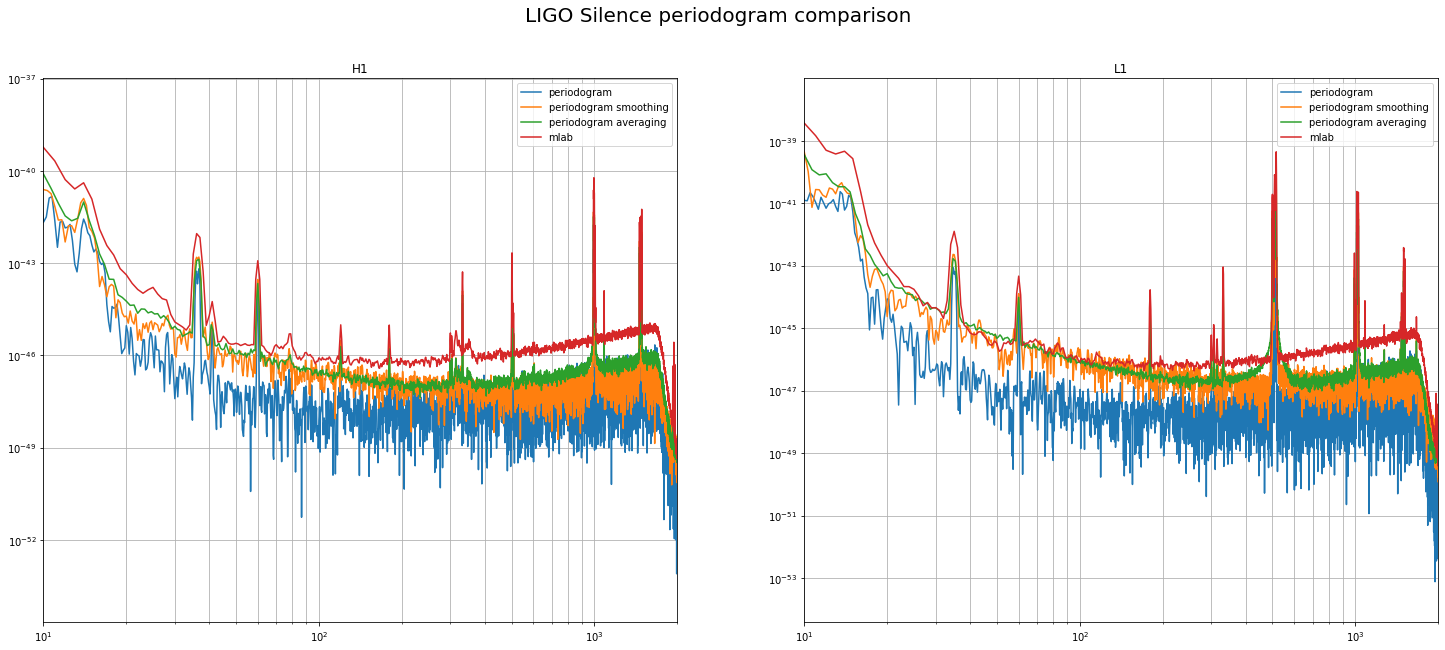

In [22]:
%%time
fig, axs = plt.subplots(1,2, figsize=(25,10))
fig.suptitle('LIGO Silence periodogram comparison', fontsize=20)

# Plotting H1
axs[0].loglog(h1_per_f*h1_fs, h1_per_best, label='periodogram')
axs[0].loglog(h1_ps_f*h1_fs, h1_ps_best, label='periodogram smoothing')
axs[0].loglog(h1_pa_f*h1_fs, h1_pa_best, label='periodogram averaging')
axs[0].loglog(h1_mlab_f, h1_mlab_best, label='mlab')


axs[0].set_xlim(10,2000)
axs[0].grid(axis='both', which='both')
axs[0].set_title('H1')
axs[0].legend()

# Plotting L1
axs[1].loglog(l1_per_f*l1_fs, l1_per_best, label='periodogram')
axs[1].loglog(l1_ps_f*l1_fs, l1_ps_best, label='periodogram smoothing')
axs[1].loglog(l1_pa_f*l1_fs, l1_pa_best, label='periodogram averaging')
axs[1].loglog(h1_mlab_f, l1_mlab_best, label='mlab')

axs[1].set_xlim(10,2000)
axs[1].grid(axis='both', which='both')
axs[1].set_title('L1')
axs[1].legend()

In [23]:
%%time
from ej2.whitenning import whiten, band_pass_filter
from scipy.interpolate import interp1d

# Generate interpolated spectrum
h1_interp_psd = interp1d(h1_mlab_f, h1_mlab_best, kind='nearest', bounds_error=False, assume_sorted=True)
l1_interp_psd = interp1d(l1_mlab_f, l1_mlab_best, kind='nearest', bounds_error=False, assume_sorted=True)

# Signal whitening
h1_whitened_signal = whiten(h1_event, h1_interp_psd, 1/h1_fs)
l1_whitened_signal = whiten(l1_event, l1_interp_psd, 1/l1_fs)

# Passband filter
h1_filtered_whitened_signal = band_pass_filter(h1_whitened_signal, h1_fs, [37,335]) # 20, 400 pero es mejor 35,350 ,37,335
l1_filtered_whitened_signal = band_pass_filter(l1_whitened_signal, l1_fs, [37,335])

Wall time: 14 ms


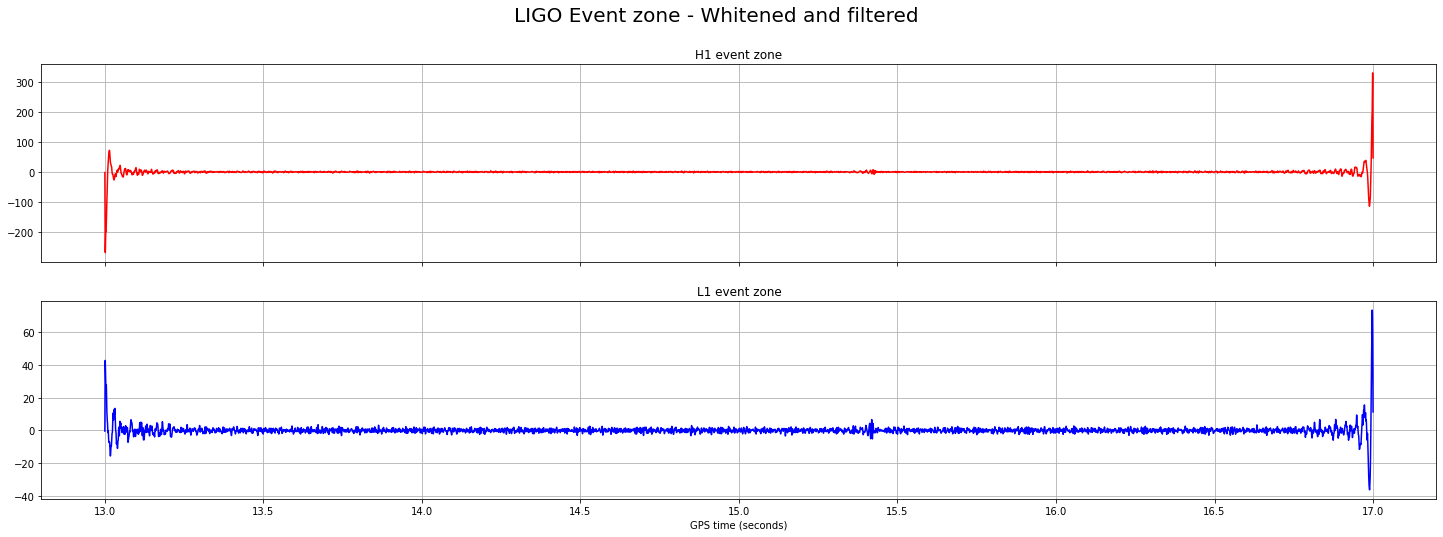

In [24]:
# Plot H1 and L1 signals
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Event zone - Whitened and filtered',fontsize=20)
axs[0].plot(time_event, h1_filtered_whitened_signal, color='red')
axs[1].plot(time_event, l1_filtered_whitened_signal, color='blue')
axs[0].set_title('H1 event zone')
axs[1].set_title('L1 event zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

In [25]:
# Flip
N = len(l1_filtered_whitened_signal)
l1_filtered_whitened_signal[int(N/2):] *= -1

# Shift event
h1_shifted_event = np.fft.fftshift(h1_filtered_whitened_signal)
l1_shifted_event = np.fft.fftshift(l1_filtered_whitened_signal)

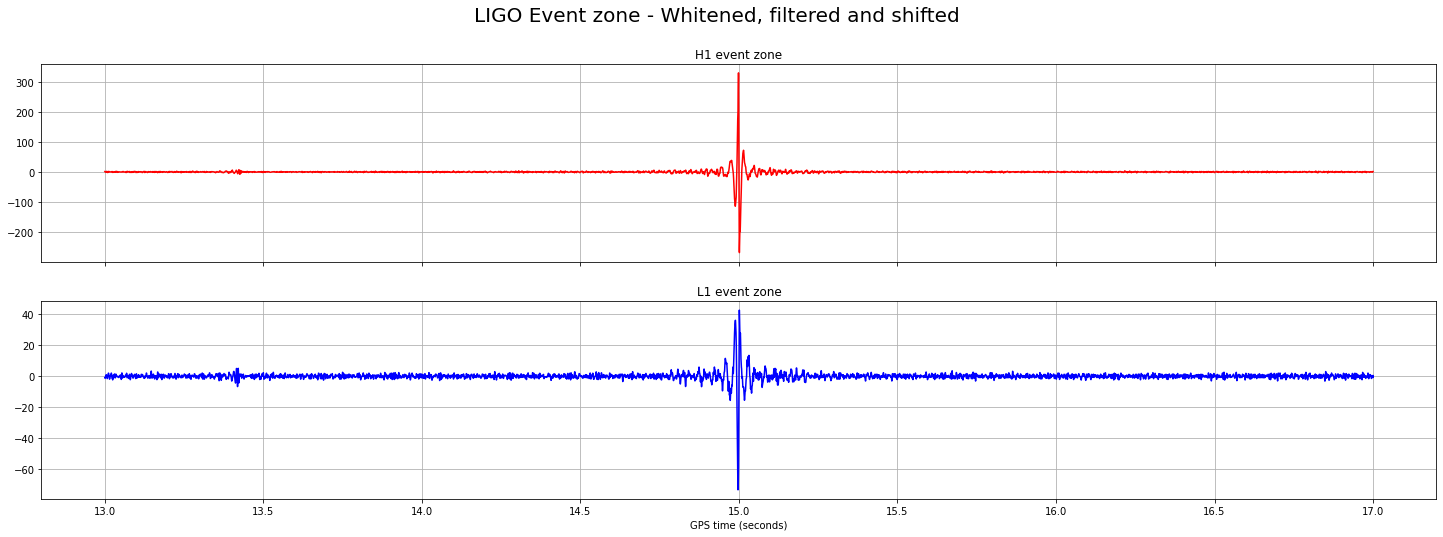

In [26]:
# Plot raw events
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Event zone - Whitened, filtered and shifted',fontsize=20)
axs[0].plot(time_event, h1_shifted_event, color='red')
axs[1].plot(time_event, l1_shifted_event, color='blue')
axs[0].set_title('H1 event zone')
axs[1].set_title('L1 event zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

In [27]:
import scipy.io.wavfile
# Scale signal to fit WAV format
h1_shifted_event_scaled = np.int16(h1_shifted_event/np.max(np.abs(h1_shifted_event)) * 32767 * 0.9)
l1_shifted_event_scaled = np.int16(l1_shifted_event/np.max(np.abs(l1_shifted_event)) * 32767 * 0.9)

# Save WAV files
scipy.io.wavfile.write('./output/h1_event.wav', int(h1_fs), h1_shifted_event_scaled)
scipy.io.wavfile.write('./output/l1_event.wav', int(l1_fs), l1_shifted_event_scaled)

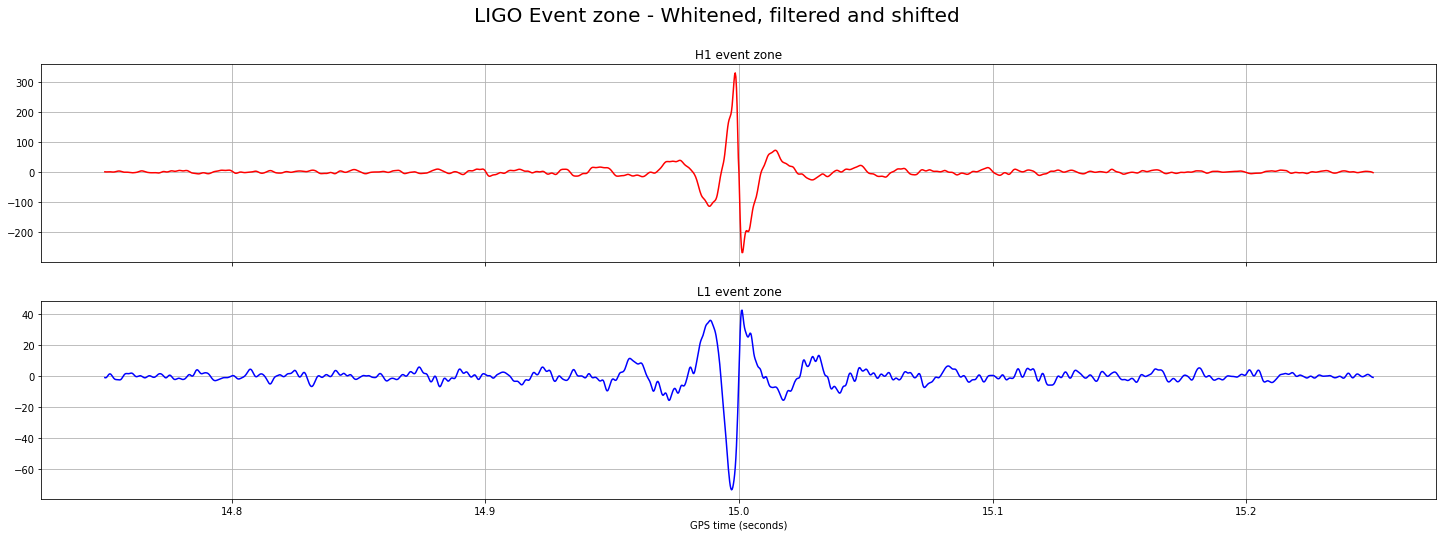

In [28]:
# Plot zoomed events
fig, axs = plt.subplots(2, sharex=True, figsize=(25,8))
fig.suptitle('LIGO Event zone - Whitened, filtered and shifted',fontsize=20)
axs[0].plot(time_event[(time_event >= 14.75) & (time_event <= 15.25)], h1_shifted_event[(time_event >= 14.75) & (time_event <= 15.25)], color='red')
axs[1].plot(time_event[(time_event >= 14.75) & (time_event <= 15.25)], l1_shifted_event[(time_event >= 14.75) & (time_event <= 15.25)], color='blue')
axs[0].set_title('H1 event zone')
axs[1].set_title('L1 event zone')
axs[1].set_xlabel('GPS time (seconds)')
axs[0].grid()
axs[1].grid()

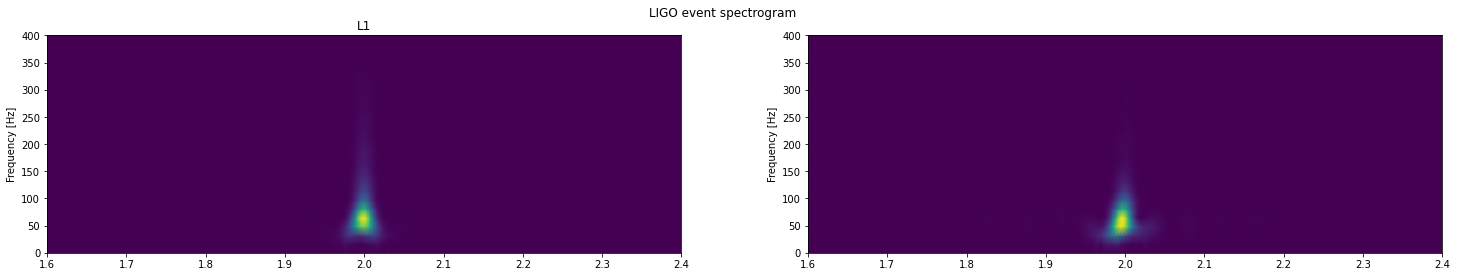

In [29]:
h1_f, h1_t, h1_sxx = sps.spectrogram(h1_shifted_event, h1_fs, window='blackman', nperseg=256, noverlap=240)
l1_f, l1_t, l1_sxx = sps.spectrogram(l1_shifted_event, l1_fs, window='blackman', nperseg=256, noverlap=240)

fig, axs = plt.subplots(1,2, figsize=(25,4))
fig.suptitle('LIGO event spectrogram')

# Plot H1 spectrogram
axs[0].pcolormesh(h1_t, h1_f, h1_sxx, shading='gouraud')
axs[0].set_ylabel('Frequency [Hz]')
axs[0].set_label('Time [sec]')
axs[0].set_ylim(0,400)
axs[0].set_xlim(1.6,2.4)
axs[0].set_title('H1')

# Plot L1 spectrogram
axs[1].pcolormesh(l1_t, l1_f, l1_sxx, shading='gouraud')
axs[1].set_ylabel('Frequency [Hz]')
axs[1].set_label('Time [sec]')
axs[1].set_ylim(0,400)
axs[1].set_xlim(1.6,2.4)
axs[0].set_title('L1');

## Cross correlation

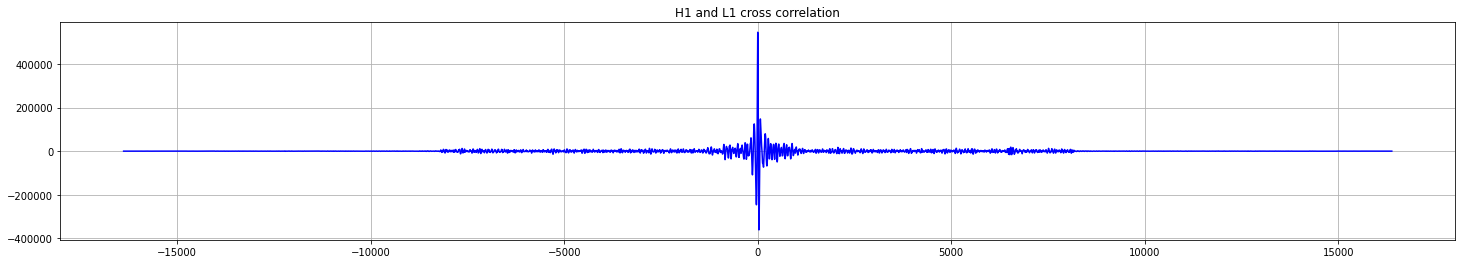

delta time is 0.244 ms


In [30]:
x_corr = np.correlate(h1_shifted_event, -1 * l1_shifted_event, 'full')
plt.figure(figsize=(25,4))
taps = np.arange(0, x_corr.shape[0], 1) - len(h1_shifted_event) + 1
plt.plot(taps, x_corr, color='blue')
plt.title('H1 and L1 cross correlation')
plt.grid()
plt.show()
print(f'delta time is {( (np.argmax(np.abs(x_corr)) - (len(h1_shifted_event)-1) ) /h1_fs) * 1e3:.3f} ms')

In [31]:
filename = 'h1_event'
print(filename + '.wav')
Audio('./output/' + filename + '.wav')

h1_event.wav


In [32]:
filename = 'l1_event'
print(filename + '.wav')
Audio('./output/' + filename + '.wav')

l1_event.wav
